# Answering Business Questions Using SQL

In this project, we will be working with a database called 'Chinook' which contains information about a fictional digital music shop, which can be found [here](https://github.com/lerocha/chinook-database). An overview of the database schema can be found below:


![alt text](chinook_db.png "Title")


The database stores data in eleven different tables. The employee, customer, invoice, invoice_line and track tables will be the focus of this project since the include various important information that can be helpful determine trends in the shopping behaviour of customers. In the schema, table names are shown in bold, while the shaded columns indicate the existence of a primary key.

### Goal of this project

The goal of this project is to:
- Measure sales representatives performace
- Analyze sales data for each country
- Use the data to make future recommendations for the store's management


<br>
<br>

In this project, we will be using Python's SQLite module to query the database.

## Creating Helper Functions

In order to save time down the line, we will create some helper functions in combination with using a context manager for handling the connection to the SQLite database.

In [10]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline


db = 'chinook.db'

# Creating a function that will take in a query and return
# a dataframe using the with statement to access the conext 
# manager for SQLite

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
# Creating a function that takes a SQL command as an argument
# and executes it using SQLite

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

# Creating a function that will call the run_query function()
# in order to return a list of all tables and views in a 
# database

def show_tables():
    q = '''
    SELECT
        name, 
        type
    FROM sqlite_master
    WHERE type IN ('table','view')
    '''
    
    return run_query(q)

# Displaying all the tables of the database
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


Like mentioned in the introduction above, the database consists of 11 different tables.

# Selecting New Albums to Purchase

After setting up the database, the next step will be to decide which albums should be added to the music store. The store just signed a new record label and three albums from the following list should be selected.
<br><br>

|    | Artist Name          | Genre         | 
|--- | -------------------- |:-------------:| 
|1   | Regal                | Hip-Hop       | 
|2   | Red Tone             | Punk          |   
|3   | Meteor and the Girls | Pop           |  
|4   | Slim Jim Bites       | Blues         |

<br>
In order to answer this question, we have to perform some querying to get a better understanding about the popularity of each record label. The following query returns each record of the Chinook database and the corresponding total number of tracks sold and the percentage of total sales for each genre.

In [11]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
    (
    SELECT il.* 
    FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id=i.invoice_id
    INNER JOIN customer c on i.customer_id=c.customer_id
    WHERE c.country="USA"
    )

SELECT 
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) /
    (SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id=uts.track_id
INNER JOIN genre g on g.genre_id=t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
'''
run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Looking at the results, the rock genre makes up the most of all sales with over 50 percent. Since hip-hop is the least popular genre when it comes to total sales at Chinook, I would recommend to not album from the artist Regal to the inventory. At the same time, the pop genre barely accumulates more sales than hip-hop. Therefore, the pop album by Meteor and the Girls can be considered for not adding to the store's inventory, too. Since the other two albums are from more popular genres (Punk and Blues) they should be added in order to increase the probability of higher sales numbers.

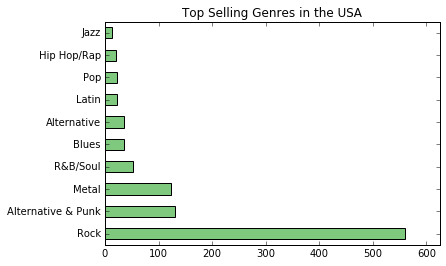

In [13]:
# Creating a dataframe genres_sales_usa and displaying the 
# number of records sold per genre in a bar chart
genres_sales_usa = run_query(albums_to_purchase)
genres_sales_usa.set_index("genre", inplace=True, drop=True)

genres_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

plt.show()

# Analyzing Employee Sales Performance

Since each customer gets a sales support agent assigned when they make their first purchase, it will be insightful to see which sales agent is performing better than others. This can be done in two steps.
1. First, we have to get the total amount of money spent by custmer with the total of the invoice table
2. Second, we have to get the total amount of money generated per employee through the table of the first step

In [14]:
sales_performance = '''
WITH customer_total AS
    (
    SELECT 
        c.customer_id id,
        c.first_name || " " || c.last_name customer_name,
        SUM(i.total) customer_total,
        c.support_rep_id rep
    FROM invoice i
    INNER JOIN customer c ON i.customer_id=c.customer_id
    GROUP BY 1
    ORDER BY 3 DESC
    )

SELECT 
    e.employee_id id,
    e.first_name || " " || e.last_name,
    SUM(ct.customer_total),
    e.hire_date,
    e.reports_to,
    e.title,
    e.country
FROM customer_total ct
INNER JOIN employee e ON ct.rep=e.employee_id
GROUP BY  1
ORDER BY 3 DESC
'''

run_query(sales_performance)


,id,"e.first_name || "" "" || e.last_name",SUM(ct.customer_total),hire_date,reports_to,title,country
0,3,Jane Peacock,1731.51,2017-04-01 00:00:00,2,Sales Support Agent,Canada
1,4,Margaret Park,1584.00,2017-05-03 00:00:00,2,Sales Support Agent,Canada
2,5,Steve Johnson,1393.92,2017-10-17 00:00:00,2,Sales Support Agent,Canada


The results show differences in the sum of the amount of sales per salses representative. But, we have to be careful with conclusions, since the three sales representatives got hired at different dates. Therefore, sales representative's performance can not confidently be analyzed with the query above since the factor of working time did not get included. We can only see that the longer a sales representative works at the company, the higher the sum of sales he accumulated. 

## Analyzing Sales by Country

Next, we will be interested gather data for each country. We are particulary interested in the total number of customers, the total value of sales, the average value of sales per customer, and the average order value, all for each country. First, let's create a view that returns the total number of customers for each country.

In [19]:
countries = '''
CREATE VIEW sorted_countries2 AS
    SELECT
        country,
        count(customer_id) count
    FROM customer
    GROUP BY 1
    ORDER BY 2 DESC
'''

run_command(countries)

q1='SELECT * FROM sorted_countries2'
run_query(q1)

,country,count
0,USA,13
1,Canada,8
2,Brazil,5
3,France,5
4,Germany,4
5,United Kingdom,3
6,Czech Republic,2
7,India,2
8,Portugal,2
9,Argentina,1


We can see that our online store has customers in 24 countries worldwide. What stands out is that we have a lot of countries with just one customer. Analyzing data for these countries will most likely not tell us much about each country and will make our overall analysis cumbersome. As a result, we will group all countries with only one customer together into a value called 'Other'.

This newly created table gives us a better overview about each countries sales.

In [25]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers
    FROM country_or_other
    GROUP BY country
    ORDER BY customers DESC
    );
'''

run_query(sales_by_country)

,country,customers
0,Other,15
1,USA,13
2,Canada,8
3,Brazil,5
4,France,5
5,Germany,4
6,United Kingdom,3
7,Czech Republic,2
8,India,2
9,Portugal,2


Now, we want query for all the information at once. We already have information about the total number of customers for each country. We can calculate the average price per order per country by dividing the sum of all units by the number of unique invoice records. Furthermore, the average customer lifetime value can be calculated by deviding the total sum per country by the number of customers.

In [27]:
sales_by_country = '''
WITH country_or_other AS
    (
    SELECT
        CASE
            WHEN (
                SELECT COUNT(*)
                FROM customer 
                WHERE country = c.country
                ) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        c.customer_id,
        il.*
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id=il.invoice_id
        INNER JOIN customer c ON c.customer_id=i.customer_id
    )
    
SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );'''



run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


From the dataframe we can see that the customers from the USA account for most of the toal sales followed by Canada and Brazil. The Czech Republic's customers have by far the highest customer lifetime value, but only have two customers total. Furthermore, we can see that the average order size does not differ a lot between countries.

## Visualizing Sales by Country

Next, we want to visualize the data we have selected above to communicate our findings. 

In [28]:
# Importing matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# Saving the data from the sales_by_country query as a 
# dataframe called country_metrics
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", inplace=True)

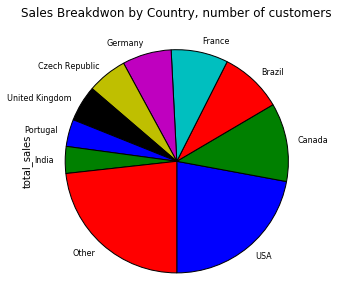

In [31]:
# Creating a pie plot for the number of customers
fig, axes = plt.subplots(1,1, figsize=(5,5))
sales_breakdown = country_metrics["total_sales"]
sales_breakdown.plot.pie(
    title='Sales Breakdwon by Country, Number of Customers',
    fontsize=8,
    startangle=-90
)

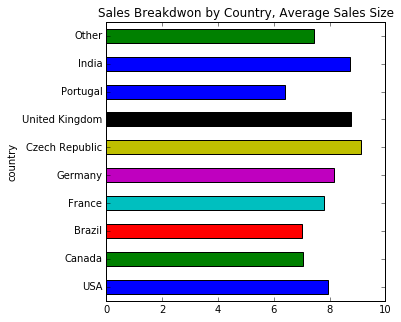

In [37]:
# Creating a bar plot for the average sales size per country
fig, axes = plt.subplots(1,1, figsize=(5,5))
sales_breakdown = country_metrics["average_order"]
sales_breakdown.plot.barh(
    title='Sales Breakdwon by Country, Average Sales Size',
)

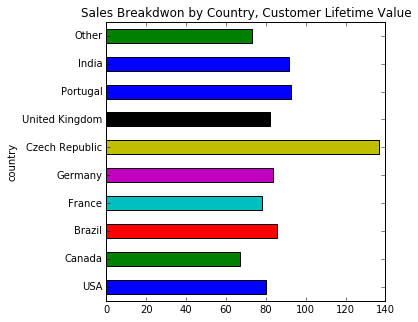

In [40]:
# Creating a bar plot for the average customer lifetime
# value for each country
fig, axes = plt.subplots(1,1, figsize=(5,5))
sales_breakdown = country_metrics["customer_lifetime_value"]
sales_breakdown.plot.barh(
    title='Sales Breakdwon by Country, Customer Lifetime Value',
)

The charts show that the USA and Canada account for roughly 30 percent of all customers. In addition, the USA has a solid average order size as well as average customer lifetime value. As a result, Chinook should continue to focus on the United States.

## Albums vs Individual Tracks

At Chinook, customers have to options to make a purchase. They can either 
- purchase an entire album
- purchase a collection of one or more individual tracks
It is not possible for customers to purchase an entire album and add tracks manually. 
<br>
The Chinook management is thinking about changing the purchasing strategy for financial reasons. The strategy is to purchase only popular tracks from one album instead of the whole. Therefore, we want to analyze what percentage of the total sales are purchased as individual tracks or as a whole album. 
<br>
In order to answer this question, we have to identify which invoices have all tracks from one album included. This can be done using the Except statement at our query.

In [42]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


The results show that album purchases just make a small percentage (18.6%) from all invoice records. As a result, the Chinook management should follow their strategy to start purchasing popular single tracks instead of entire albums.

## Conclusion

In this project we used SQL queries to get information from a fictional digital music store database. We were able to analyze the popularity of genres, customer and sales data per country, and the percentage of albumns sold. Furthermore, we made recommendation for the management about future purchasing strategies.